# IMPORTATION DES PACKAGES

In [1]:
import pandas as pd
from sklearn import tree
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
import numpy as np
#from sklearn.inspection import DecisionBoundaryDisplay
#import shap

def deco(x):
    print(str(x)*100)
    

# Description et visualisation du jeu de données

In [2]:
# les fonctions definitives pour eviter de faire cellule par cellule
def description(file):
    data = pd.read_csv(file)
    print("le jeu de données contient ",data.shape[0]," lignes et ", data.shape[1]," colonnes\n")
    print("les 10 premières du jeu de données :\n")
    print(data.head())
    print("les différents types de données:\n")
    print(data.dtypes)
    print("la description des données de type numériques:\n")
    print(data.describe())
    print("la distribution des observations en fonction de la variable cible:\n")
    round(data["Result"].value_counts(normalize=True),2)
    
    return(data)
    

def visualisation (data, Y, title):
    # print("la distribution des observations en fonction de la variable cible:\n")
    round(data["Result"].value_counts(normalize=True),2)
    sns.countplot(x=Y, data=data)
    plt.xlabel('Les 2 types de résultats')
    plt.ylabel('Nombre d\'occurrences')
    plt.title(title)
    plt.show()
    
    data.dtypes.value_counts().plot.pie()
    plt.show()
    
    sns.scatterplot(data=data, x="Systolic blood pressure", y="Age", hue=data["Result"])
    plt.title("Scatter plot of systolic pressure by age")
    plt.show()
    
    #sns.pairplot(data)
    #plt.show()
    for col in data.select_dtypes(['int','float']):
        plt.figure
        sns.boxplot(data[col])
        plt.title(col)
        plt.show()
    
def split(data,size,class_label):
    train_set, test_set = train_test_split(data, train_size=size, random_state=0, stratify=class_label)
    return train_set, test_set


def split_2(train_set, test_set):
    y_test = test_set["Result"]
    y_train = train_set["Result"]
    # encoder = preprocessing.LabelEncoder()
    # Y_encd = encoder.fit_transform(Y)
    x_train = train_set.iloc[:, [0, 1, 2, 3]]
    x_test = test_set.iloc[:, [0, 1, 2, 3]]
    return x_train, x_test, y_train, y_test


def preprocess(data):
    data_clean = data.copy()
    for col in data_clean.select_dtypes(['int','float']).columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        # print(IQR, Q1-1.5*IQR, Q3+1.5*IQR)
        data_clean = data_clean[~((data_clean[col]<(Q1-1.5*IQR))|(data_clean[col]>(Q3+1.5*IQR)))]
    return(data_clean)

le jeu de données contient  1319  lignes et  9  colonnes

les 10 premières du jeu de données :

   Age  Gender  Heart rate  Systolic blood pressure  Diastolic blood pressure  \
0   64       1          66                      160                        83   
1   21       1          94                       98                        46   
2   55       1          64                      160                        77   
3   64       1          70                      120                        55   
4   55       1          64                      112                        65   

   Blood sugar  CK-MB  Troponin    Result  
0        160.0   1.80     0.012  negative  
1        296.0   6.75     1.060  positive  
2        270.0   1.99     0.003  negative  
3        270.0  13.87     0.122  positive  
4        300.0   1.08     0.003  negative  
les différents types de données:

Age                           int64
Gender                        int64
Heart rate                    int64
Systolic bl

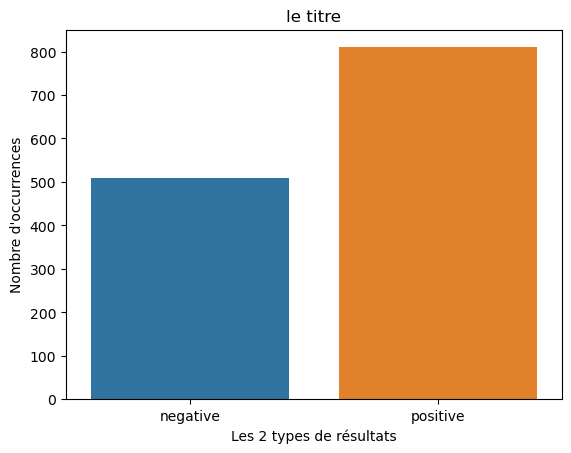

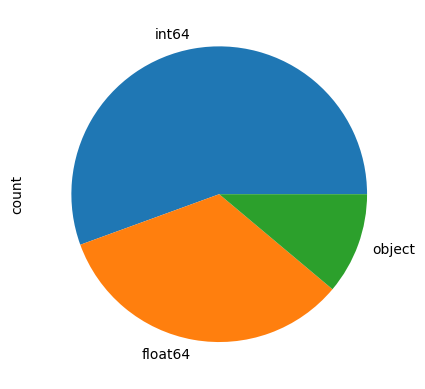

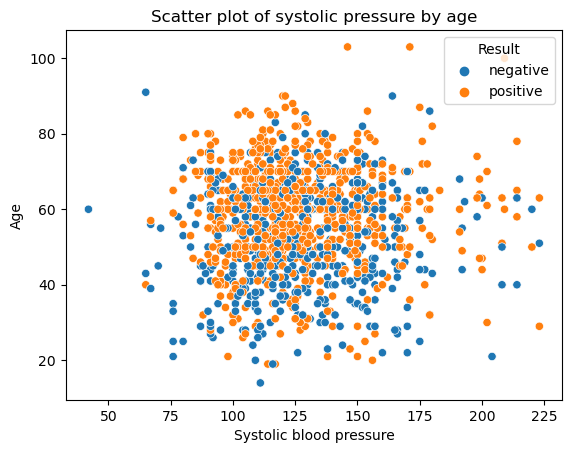

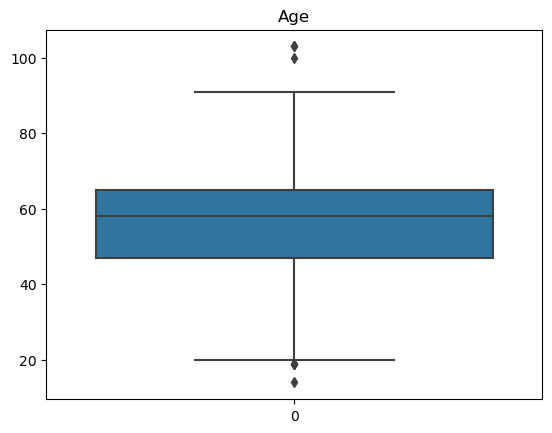

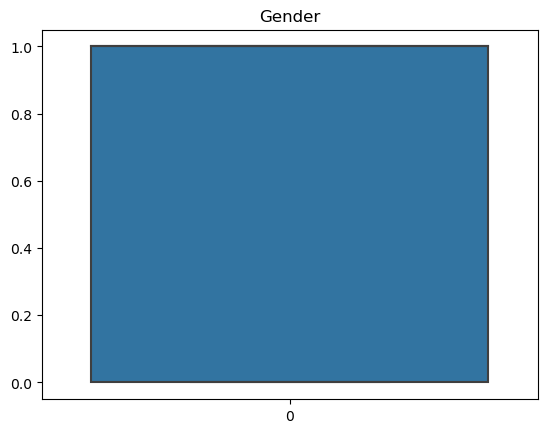

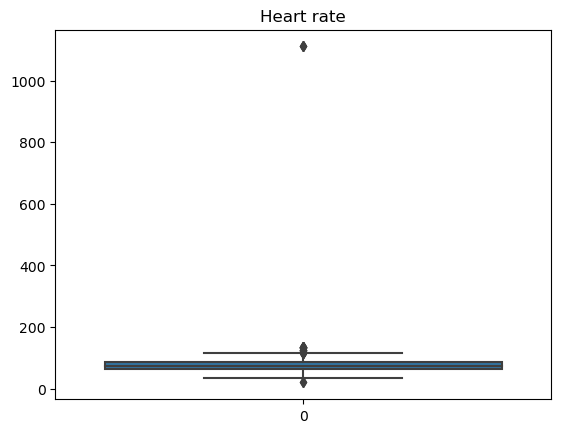

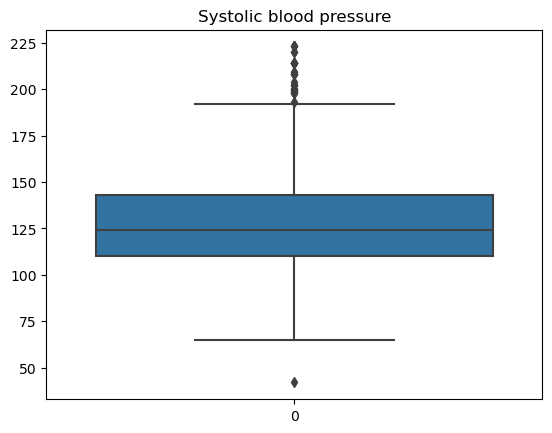

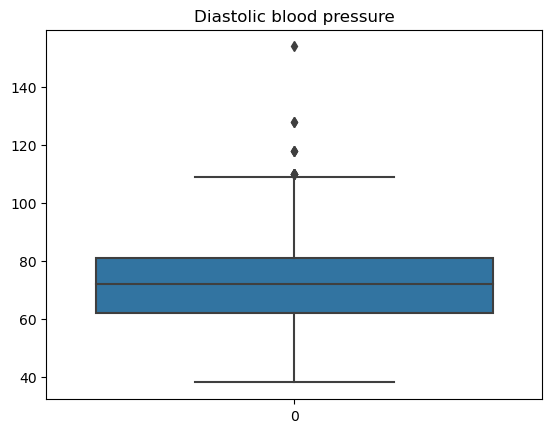

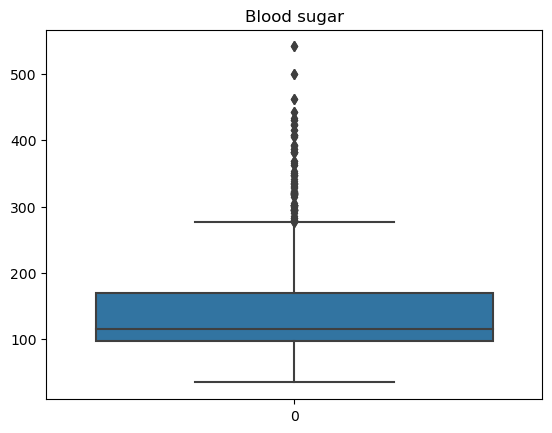

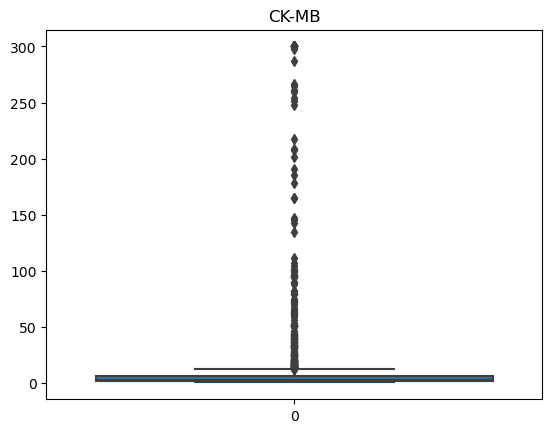

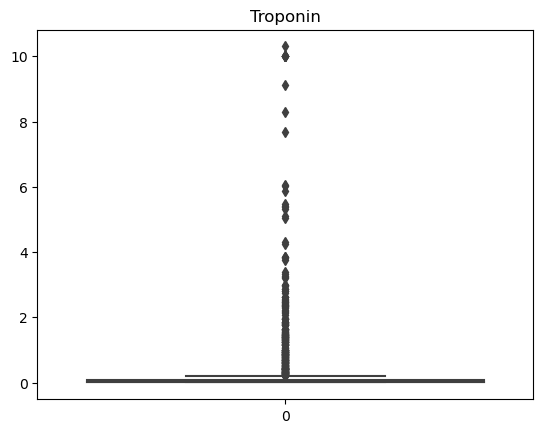

la distribution des classes dans le train set :
 Result
0    0.57
1    0.43
Name: proportion, dtype: float64
____________________________________________________________________________________________________
la distribution des classes dans le test set :
 Result
0    0.56
1    0.44
Name: proportion, dtype: float64


In [3]:
# Description
data=description("Medicaldataset.csv")
visualisation(data, data["Result"],"le titre")

# Prepocessing
data_clean = preprocess(data)

# encodage des variables 
# variable target
label = preprocessing.LabelEncoder()
data_clean['Result'] = label.fit_transform(data_clean['Result'])
# variable binaire
binary = preprocessing.LabelBinarizer()
data_clean['Gender'] = binary.fit_transform(data_clean['Gender'])
# visualisation de l'après nettoyage
#for col in data_clean.select_dtypes(['int','float']):
#    plt.figure
#    sns.boxplot(data_clean[col])
#    plt.show()
data_clean.head()

#Train test split
train_set, test_set = split(data_clean, 0.8, data_clean["Result"])
# visualisation
print("la distribution des classes dans le train set :\n", round(train_set['Result'].value_counts(normalize=True),2))
deco("_")
print("la distribution des classes dans le test set :\n", round(test_set['Result'].value_counts(normalize=True),2))

x_train, x_test, y_train, y_test = split_2(train_set, test_set)


### Preprocessing 2

Formule pour calculer la FCM (fréquence cardiaque maximale) :  
Homme : ```FCM = 220 - votre âge```  
Femme : ```FCM = 226 - votre âge```  
Source : <a href="https://www.decathloncoach.com/fr/home/advices/advice/frequence-cardiaque-reserve-repos-et-maximale">Décathlon coach</a>

Autre formule pour calculer sa FCM (fréquence cardiaque maximale) :  
```FCM = 207 – 0,7 x âge```  
Source : <a href="https://www.irbms.com/calculer-sa-frequence-cardiaque-pour-un-effort/">IRBMS</a>

In [168]:
def preprocess2(data):
    x_data_2 = data.drop(columns = ['Systolic blood pressure'])
    #Calculer si les BPM sont possibles
    x_data_2['BPM_possible'] = False
    x_data_2.loc[x_data_2['Heart rate']<= 207 - (0.7*x_data_2['Age']), 'BPM_possible'] = True
    x_data_2.loc[x_data_2['BPM_possible'] == False]
    data2 = x_data_2.loc[x_data_2['BPM_possible']==True]
    
    label = preprocessing.LabelEncoder()
    data2['Result'] = label.fit_transform(data2['Result'])
    # variable binaire
    binary = preprocessing.LabelBinarizer()
    data2['Gender'] = binary.fit_transform(data2['Gender'])
    
    
    return(data2.drop('BPM_possible',axis=1))

In [169]:
data_clean2 = preprocess2(data)
data_clean2.head()

,Age,Gender,Heart rate,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,83,160.0,1.80,0.012,0
1,21,1,94,46,296.0,6.75,1.060,1
2,55,1,64,77,270.0,1.99,0.003,0
3,64,1,70,55,270.0,13.87,0.122,1
4,55,1,64,65,300.0,1.08,0.003,0


In [170]:
#Train test split
train_set2, test_set2 = split(data_clean2, 0.8, data_clean2["Result"])
# visualisation
print("la distribution des classes dans le train set 2 :\n", round(train_set2['Result'].value_counts(normalize=True),2))
deco("_")
print("la distribution des classes dans le test set 2 :\n", round(test_set2['Result'].value_counts(normalize=True),2))

x_train2, x_test2, y_train2, y_test2 = split_2(train_set2, test_set2)

la distribution des classes dans le train set 2 :
 Result
1    0.61
0    0.39
Name: proportion, dtype: float64
____________________________________________________________________________________________________
la distribution des classes dans le test set 2 :
 Result
1    0.61
0    0.39
Name: proportion, dtype: float64


## Correlation matrix here

# Application des modèles

In [201]:
def deco(x):
    print(str(x)*100)
    
def split(data,size,class_label):
    train_set, test_set = train_test_split(data, train_size=size, random_state=0, stratify=class_label)
    return train_set, test_set


def split_2(train_set, test_set):
    y_test = test_set["Result"]
    y_train = train_set["Result"]
    # encoder = preprocessing.LabelEncoder()
    # Y_encd = encoder.fit_transform(Y)
    x_train = train_set.iloc[:, 0:8]
    x_test = test_set.iloc[:, 0:8]
    return x_train, x_test, y_train, y_test

def implemantation_supervise(model, x_train, y_train, x_test, n_neighbors=3):
    #if model == KNeighborsClassifier:
        #MD = model(n_neighbors)
    #else:
    # print(model)
    
    MD = model
    mdl = MD.fit(x_train, y_train)
    
    #if str(model) == "AdaBoostClassifier()":
        #pass
    #else:
        #explainer = shap.TreeExplainer(mdl)
        #shap_values = explainer.shap_values(x_test)
        #shap.summary_plot(shap_values, x_test, title=str(MD))

        #explainer = shap.TreeExplainer(mdl)
        #shap_values = explainer.shap_values(x_test)
        #shap.summary_plot(shap_values[1], x_test.values, feature_names=x_test.columns, title=str(MD))

    y_pred = mdl.predict(x_test)

    if str(model) == "DecisionTreeClassifier()":
        tree.plot_tree(MD,
                  feature_names=['Age', 'Gender', 'Heart rate','Systolic blood pressure', 'Diastolic blood pressure','Blood sugar','CK-MB','Troponin'],
                  class_names=["Positive", "Negative"], filled=True)
        plt.show()
    
    #if str(model) == "SVC()":
        #fig, ax = plt.subplots()

        #DecisionBoundaryDisplay.from_estimator(model, x_train, cmap=plt.cm.coolwarm, alpha=0.5, ax=ax)

        # Affichage des points de données
        #scatter = ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k')

        # Légende
        #legend = ax.legend(*scatter.legend_elements(), title="Classes")
        #ax.add_artist(legend)

        plt.show()
    
    
    print("IMPLEMENTATION DE", MD)
    return y_pred

def implemantation_supervise_without_sys(model, x_train, y_train, x_test, n_neighbors=3):
    #if model == KNeighborsClassifier:
        #MD = model(n_neighbors)
    #else:
    print(model)
    
    MD = model
    mdl = MD.fit(x_train, y_train)
    
    #if str(model) == "AdaBoostClassifier()":
        #pass
    #else:
        #explainer = shap.TreeExplainer(mdl)
        #shap_values = explainer.shap_values(x_test)
        #shap.summary_plot(shap_values, x_test, title=str(MD))

        #explainer = shap.TreeExplainer(mdl)
        #shap_values = explainer.shap_values(x_test)
        #shap.summary_plot(shap_values[1], x_test.values, feature_names=x_test.columns, title=str(MD))

    y_pred = mdl.predict(x_test)

    if str(model) == "DecisionTreeClassifier()":
        tree.plot_tree(MD,
                  feature_names=['Age', 'Gender', 'Heart rate', 'Diastolic blood pressure','Blood sugar','CK-MB','Troponin'],
                  class_names=["Positive", "Negative"], filled=True)
        plt.show()
    print("IMPLEMENTATION DE", MD)
    return y_pred


def scoring(y_pred, y_test):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    print("l'accuracy :\n", accuracy)
    deco("_")
    print("la matrice de confusion\n", confusion_matrix(y_test,y_pred))
    deco("_")
    print(classification_report(y_test, y_pred))
    deco("_")
    return(accuracy, f1, recall)
    
def implementation_unsupervised(model, x_train, n_clusters=3):
    MD = model(n_clusters)
    mdl = MD.fit(x_train)
    y_pred = mdl.predict(x_test)
    if model == KMeans:
        kmeans_clusters = MD.cluster_centers_
    print("IMPLEMENTATION DE", MD)
    return y_pred, kmeans_clusters


In [202]:
mdl_sup = [DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier(), svm.SVC(),KNeighborsClassifier(),GaussianNB()]
# LinearSVC(),

In [224]:
MD = svm.SVC()
mdl = MD.fit(x_train, y_train)
y_pred = mdl.predict(x_test)



In [229]:
from sklearn.inspection import DecisionBoundaryDisplay
#!pip install scikit-learn==1.0.2

ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (/Users/carla/opt/anaconda3/lib/python3.9/site-packages/sklearn/inspection/__init__.py)

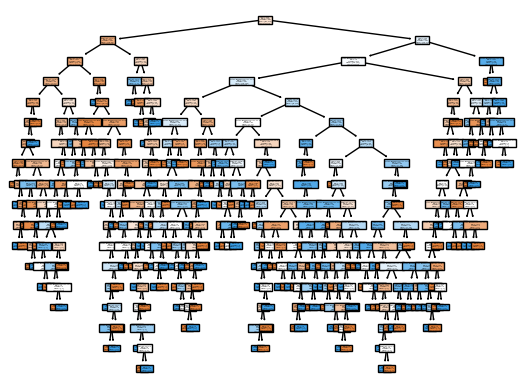

IMPLEMENTATION DE DecisionTreeClassifier()
l'accuracy :
 0.4936708860759494
____________________________________________________________________________________________________
la matrice de confusion
 [[45 44]
 [36 33]]
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.56      0.51      0.53        89
           1       0.43      0.48      0.45        69

    accuracy                           0.49       158
   macro avg       0.49      0.49      0.49       158
weighted avg       0.50      0.49      0.50       158

____________________________________________________________________________________________________
IMPLEMENTATION DE RandomForestClassifier()
l'accuracy :
 0.5949367088607594
____________________________________________________________________________________________________
la matrice de confusion
 [[56 33]
 [31 38]]
_____________________________

In [203]:
acc_sup = []
f1_sup = []
recall_sup = []

for m in mdl_sup:
    y_pred = implemantation_supervise(m, x_train, y_train, x_test)
    acc, f1,recall = scoring(y_pred, y_test)
    acc_sup.append(acc)
    f1_sup.append(f1)
    recall_sup.append(recall)
    

In [232]:
f1_sup.index(max(f1_sup))
#print(f1_sup)
#print(max(f1_sup))
mdl_sup[f1_sup.index(max(f1_sup))]
np.argmax(f1_sup)
mdl_sup[1]

RandomForestClassifier()

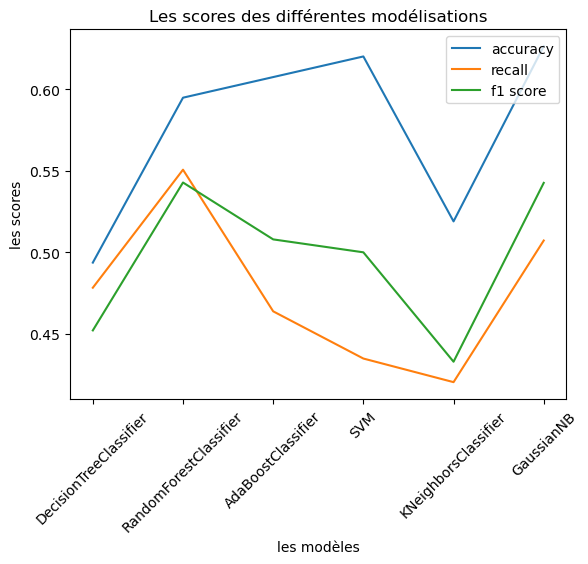

In [204]:
#Afficher la liste des scores dans une courbe
#print(score_list)
mdl_ls = ["DecisionTreeClassifier", "RandomForestClassifier","AdaBoostClassifier", "SVM","KNeighborsClassifier","GaussianNB"]
# "LinearSVC",
fig, ax = plt.subplots()
ax.set(title="Les scores des différentes modélisations",
           ylabel="les scores",
          xlabel="les modèles")
ax.set_xticklabels(mdl_ls, rotation =45)
ax.plot(mdl_ls,acc_sup, label="accuracy")
ax.plot(mdl_ls,recall_sup, label="recall")
ax.plot(mdl_ls,f1_sup, label="f1 score")
plt.legend()

DecisionTreeClassifier()


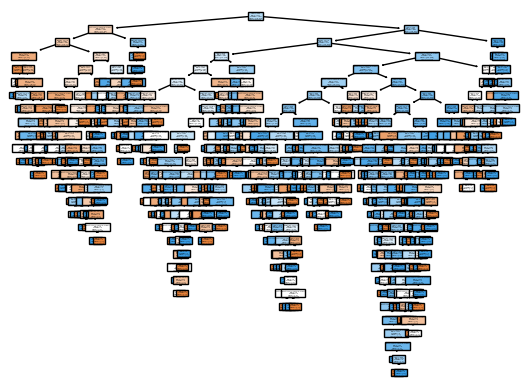

IMPLEMENTATION DE DecisionTreeClassifier()
l'accuracy :
 0.5643939393939394
____________________________________________________________________________________________________
la matrice de confusion
 [[ 43  59]
 [ 56 106]]
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.43      0.42      0.43       102
           1       0.64      0.65      0.65       162

    accuracy                           0.56       264
   macro avg       0.54      0.54      0.54       264
weighted avg       0.56      0.56      0.56       264

____________________________________________________________________________________________________
RandomForestClassifier()
IMPLEMENTATION DE RandomForestClassifier()
l'accuracy :
 0.5871212121212122
____________________________________________________________________________________________________
la matrice de confusion
 [[ 40  62]
 [ 47 11

In [164]:
acc_sup2 = []
f1_sup2 = []
recall_sup2 = []

for m in mdl_sup:
    y_pred = implemantation_supervise_without_sys(m, x_train2, y_train2, x_test2)
    acc, f1,recall = scoring(y_pred, y_test2)
    acc_sup2.append(acc)
    f1_sup2.append(f1)
    recall_sup2.append(recall)
    
    

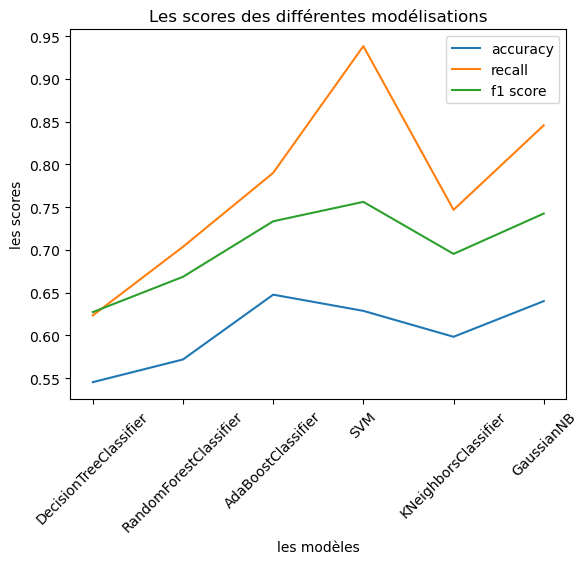

In [162]:
#Afficher la liste des scores dans une courbe
#print(score_list)
mdl_ls = ["DecisionTreeClassifier", "RandomForestClassifier","AdaBoostClassifier", "SVM","KNeighborsClassifier","GaussianNB"]
# "LinearSVC",
fig, ax = plt.subplots()
ax.set(title="Les scores des différentes modélisations",
           ylabel="les scores",
          xlabel="les modèles")
ax.set_xticklabels(mdl_ls, rotation =45)
ax.plot(mdl_ls,acc_sup2, label="accuracy")
ax.plot(mdl_ls,recall_sup2, label="recall")
ax.plot(mdl_ls,f1_sup2, label="f1 score")
plt.legend()

# Application modèles nonsupervisés

In [ ]:
data_clean_unlabeled = data_clean.drop("Result", axis=1)
data_clean_unlabeled

# KMEANS

Visualiser le résultat
Metriques
Itérer pour trouver le nombre max de clusters
EXPLIMER LIMITE CLUSTERING AGGLOMERATIF AVEC UN EXEMPLE DE JEU DE DONNEES

In [ ]:
kmeans = KMeans(n_clusters = 2, random_state=47, n_init="auto").fit(data_clean_unlabeled)
kmeans.cluster_centers_

Comparaison avec le vrai dataset

In [ ]:
print((kmeans.labels_ == data_clean['Result']).value_counts())
#L'algorithme ne prédit pas vraiment bien les classes par rapport à ce que l'on s'attend d'obtenir

ACP Réduction en 2 ou 3 dimension pour visualisation

In [ ]:
#PCA pour 3 composantes, pas très performant
pca = PCA(n_components = 3).fit(data_clean_unlabeled)
pca.explained_variance_ratio_

In [ ]:
#PCA pour 2 composantes
pca = PCA(n_components = 2).fit(data_clean_unlabeled)
pca.explained_variance_ratio_

In [ ]:
data_clean_pca = pca.transform(data_clean_unlabeled)
plt.scatter(data_clean_pca[:,0],data_clean_pca[:,1], c=kmeans.labels_)
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Répartition du clustering par ACP")

In [ ]:
pcs = pca.components_

# Longueur des variables sur les composantes principales
sqrt_eigenvalues = np.sqrt(pca.explained_variance_)

# Initialiser la figure
fig, ax = plt.subplots(figsize = (6,6))

# Tracer les axes des composantes principales
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.05, fc='r', ec='r')
    ax.text(x, y, data_clean_unlabeled.columns[i], fontsize='12')

# Ajouter un cercle
circle = plt.Circle((0,0), 1, color='b', fill=False)
ax.add_artist(circle)

# Définir les limites des axes
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Label et titre
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Cercle de corrélation pour ACP")

# Afficher
plt.show()

# Clustering hiérarchique

Nombre prédef de cluster (2)
Plot dendogram
metrics
nombre optimal de cluster (useless)
expliquer limite

In [ ]:
hierarchClustering = AgglomerativeClustering(n_clusters=2).fit(data_clean_unlabeled)

In [ ]:
hierarchClustering.labels_

In [ ]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
hierarchClustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(data_clean_unlabeled)
plot_dendrogram(hierarchClustering,truncate_mode="level",p=2)

# DBSCAN

Exec avec random params
Visualiser le résultat (ACP)
metrics
itérer pour trouver bon hyperparams(time calcul)
limites

In [ ]:
dbscanModel = DBSCAN(eps =20, min_samples=15).fit(data_clean_unlabeled)

In [ ]:
dbscanModel.labels_

In [ ]:
plt.scatter(data_clean_pca[:,0],data_clean_pca[:,1], c=dbscanModel.labels_)
plt.xlabel("1ere composante")
plt.ylabel("2eme composante")
plt.title("Répartition du clustering par ACP")